### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 24th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

<span style="color:blue">


#### Problem 1 Purpose: Determine the prosterior distribution built from the liklihood and our prior. We then want to see how the prosterior distribution changes if our prior changes in both values and in distribution shape (uniform vs gaussian)
#####     - 1. We start with a data set
#####     - 2. We determine the liklihood distribution (best model for the data)
#####     - 3. We use our uniform prior and liklihood to find the posterior 
#####     - 4. We find the credible region (confidence intervals) of posterior 
#####     - 5. We try again with different uniform prior 
#####     - 6. We try again with gaussian prior
#####     - 7. Plot 3 different prosteriors
#####     - 8. We find the Bayesian Evidence

<span/>

### Solution 1

### 1.1 Read in Data find mean and sigma

In [667]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats


# Load the dataset 
data = np.load('/Users/jarretsm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw4_data_1.npy') 

# Extract data
x = data[:, 0] #first column is measurements
sigma = data[:, 1] #Second column is uncertainties

#Compute sample mean and standard error for heteroscedastic gaussian
Het_mu = (np.sum(x/ (sigma**2))) / (np.sum(1/ (sigma**2 )) )
Het_sigma = np.sum ( 1 / (sigma**2))**(-1/2)


print("Heteroscedastic Mean:", Het_mu)
print("Heteroscedastic Sigma:", Het_sigma)

Heteroscedastic Mean: 4.942118214425304
Heteroscedastic Sigma: 0.43024334605205083


### 1.2 Fit the ln-likelihood

<span style="color:blue">

### Reminder summary on Likelihood:
 

- Probability: we have distribution and want to get info on data

- Likelihood: The reverse, we know the data but want to find the most likley distribution

- Log likelihood: This is a faster way to find the liklihood distribution (computationally easier)

<span/>

In [668]:
# Write a ln-likelihood function for heteroscedastic Gaussian data
# Recall: LnL is the likelihood that the model is good given our data. For the Gaussian case, we compute the z-score for each data point
def Ln_Likelihood(mu, x, sigma):    
    Z = (x - mu) / sigma
    LnL = -0.5 * np.sum(Z**2)  # Calculate LnL (i.e. X^2 for Gaussian)
    return - LnL

# Create a fitting algorithm to find the best-fit mean.
# Note minimizing LnL maximizes the likelihood, and scipy optimizers are set up to minimize functions.
Maximize_LnL = optimize.minimize(Ln_Likelihood, x0=Het_mu, args=(x, sigma))

# Extract the best-fit mean 
best_fit_mu = Maximize_LnL.x[0]

print("Best-fit Mean from maximizing the LnL is: %.5f" % best_fit_mu) 

Best-fit Mean from maximizing the LnL is: 4.94212


### 1.3 Compute and plot the Bayesian posterior probability density

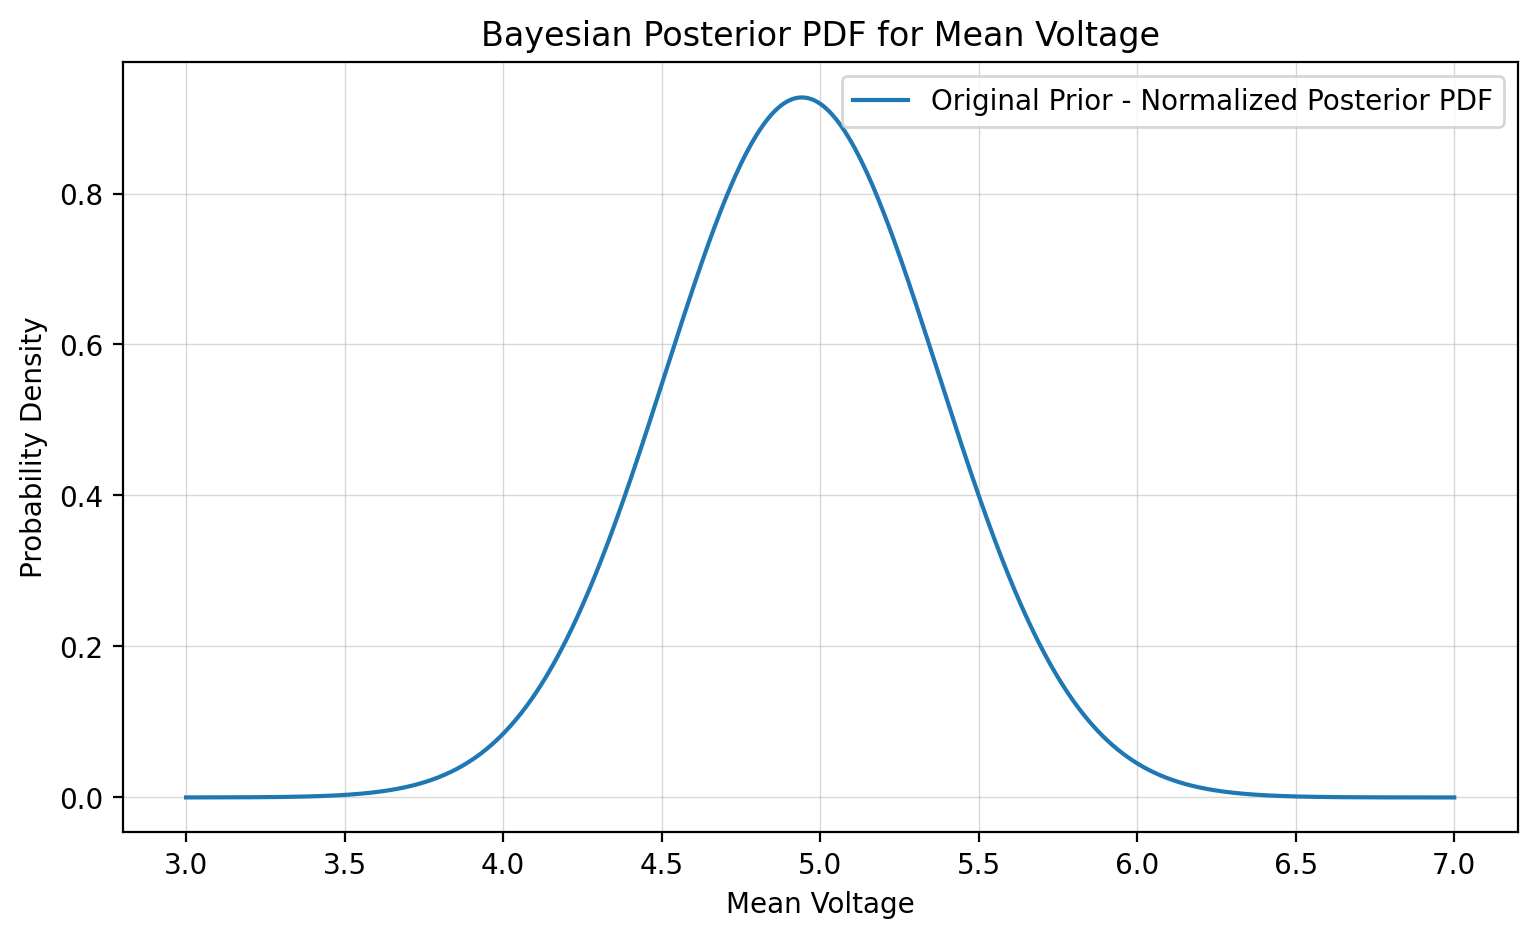

In [669]:
import numpy as np
from scipy.stats import uniform
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad


#Select min and max values of the voltage data (about 3 and 7)
X_Min=3
X_Max=7

# Define the grid for the mean voltage
mu_grid = np.linspace(X_Min, X_Max, 1000)

# Define the uniform prior
prior1 = uniform.pdf(mu_grid, loc=X_Min, scale= X_Max-X_Min) #loc is TBD

# Compute the likelihood for each value in the grid
# Exponentiate the Ln_Likelihood to get likelihood
likelihood = np.exp([-Ln_Likelihood(mu, x, sigma) for mu in mu_grid])

# Compute the posterior by multiplying the likelihood by the prior
posterior1 = likelihood * prior1

# Normalize the posterior (must sum to 1): dividing by the sum of all posterior values
posterior1 = posterior1 / np.sum(posterior1 * np.diff(mu_grid)[0])


# Plot the posterior
plt.figure(figsize=(9, 5))
plt.plot(mu_grid, posterior1, label='Original Prior - Normalized Posterior PDF')
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior PDF for Mean Voltage')
plt.legend()
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()


### 1.4 Find the credible region

In [670]:
#By drawing samples from posterior, find the equal-tailed 68.3% credible region for the mean

#Draw samples 
n_samples = 1000 
samples = np.random.choice(mu_grid, size=n_samples, p=posterior1/posterior1.sum()) #dividing by p.sum() needed to renormalize

# Calculate the 68.3% credible interval
lower_bound = np.percentile(samples, 15.85) #lower sections (2.14 + 13.59)
upper_bound = np.percentile(samples, 84.15) # uppder sections to 68.3 (2.14 + 13.59 + 68.3)



#Compare upper and lower boundaries to the sample mean plus/minus the standard error
sample_mean_plus_error = Het_mu + Het_sigma
sample_mean_minus_error = Het_mu - Het_sigma


#Find the MAP value of the mean (For what value on x-axis does the PDF peak?)
PosteriorPeak = np.argmax(posterior1) #use argmax instead of max because np.max gives max value but argmax gives index of max value

#Find x axis value for that peak (index)
MAP = mu_grid[PosteriorPeak]


#Print everything
print("Original Prior 68.3%% credible interval: [%.4f, %.4f]" % (lower_bound, upper_bound))
print("Sample mean ± standard error: [%.4f, %.4f]" % (sample_mean_minus_error, sample_mean_plus_error))
print("Original Prior MAP estimate of the mean voltage: %.4f" % MAP)

Original Prior 68.3% credible interval: [4.5095, 5.3504]
Sample mean ± standard error: [4.5119, 5.3724]
Original Prior MAP estimate of the mean voltage: 4.9419


### 1.5 Repeat (1.3) and (1.4) with new Uniform prior range

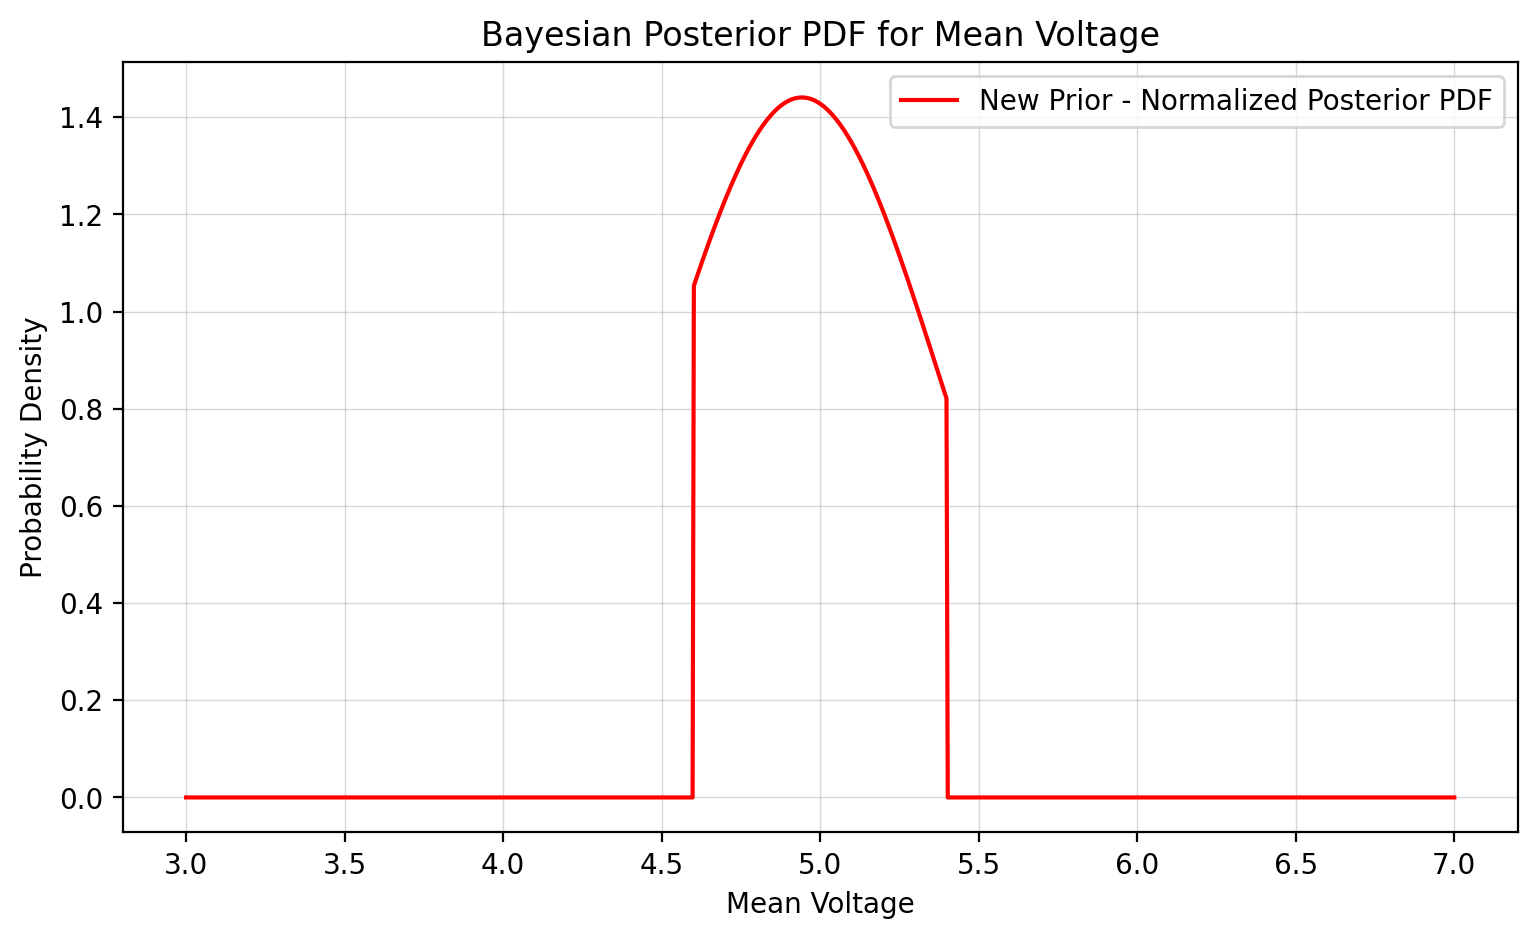

In [671]:
#Compute and plot the Bayesian posterior probability density with new prior

#Select min and max values of the voltage data (about 3 and 7)
X_Min=3
X_Max=7

NewPrior_X_Min= 4.6
NewPrior_X_Max= 5.4


# Define the grid for the mean voltage
mu_grid = np.linspace(X_Min, X_Max, 1000)

# Define the uniform prior
prior2 = uniform.pdf(mu_grid, loc=NewPrior_X_Min, scale= NewPrior_X_Max-NewPrior_X_Min) #loc is TBD

# Compute the likelihood for each value in the grid
# Exponentiate the Ln_Likelihood to get likelihood
likelihood = np.exp([-Ln_Likelihood(mu, x, sigma) for mu in mu_grid])

# Compute the posterior by multiplying the likelihood by the prior
posterior2 = likelihood * prior2

# Normalize the posterior (must sum to 1): dividing by the sum of all posterior values
posterior2 = posterior2 / np.sum(posterior2 * np.diff(mu_grid)[0])


# Plot the posterior
plt.figure(figsize=(9, 5))
plt.plot(mu_grid, posterior2, label='New Prior - Normalized Posterior PDF', color='r')
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior PDF for Mean Voltage')
plt.legend()
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()

In [672]:
#By drawing samples from posterior, find the equal-tailed 68.3% credible region for the mean for new prior

#Draw samples 
n_samples = 1000 
samples = np.random.choice(mu_grid, size=n_samples, p=posterior2/posterior2.sum()) #dividing by p.sum() needed to renormalize

# Calculate the 68.3% credible interval
lower_bound = np.percentile(samples, 15.85) #lower sections (2.14 + 13.59)
upper_bound = np.percentile(samples, 84.15) # uppder sections to 68.3 (2.14 + 13.59 + 68.3)


#Find the MAP value of the mean (For what value on x-axis does the PDF peak?)
PosteriorPeak = np.argmax(posterior2) #use argmax instead of max because np.max gives max value but argmax gives index of max value

#Find x axis value for that peak (index)
MAP = mu_grid[PosteriorPeak]


#Print everything
print("New Prior 68.3%% credible interval: [%.4f, %.4f]" % (lower_bound, upper_bound))
print("MAP estimate of the mean voltage: %.4f" % MAP)

New Prior 68.3% credible interval: [4.7457, 5.2382]
MAP estimate of the mean voltage: 4.9419


### 1.6 Repeat (1.3) and (1.4) with new Gaussian prior range

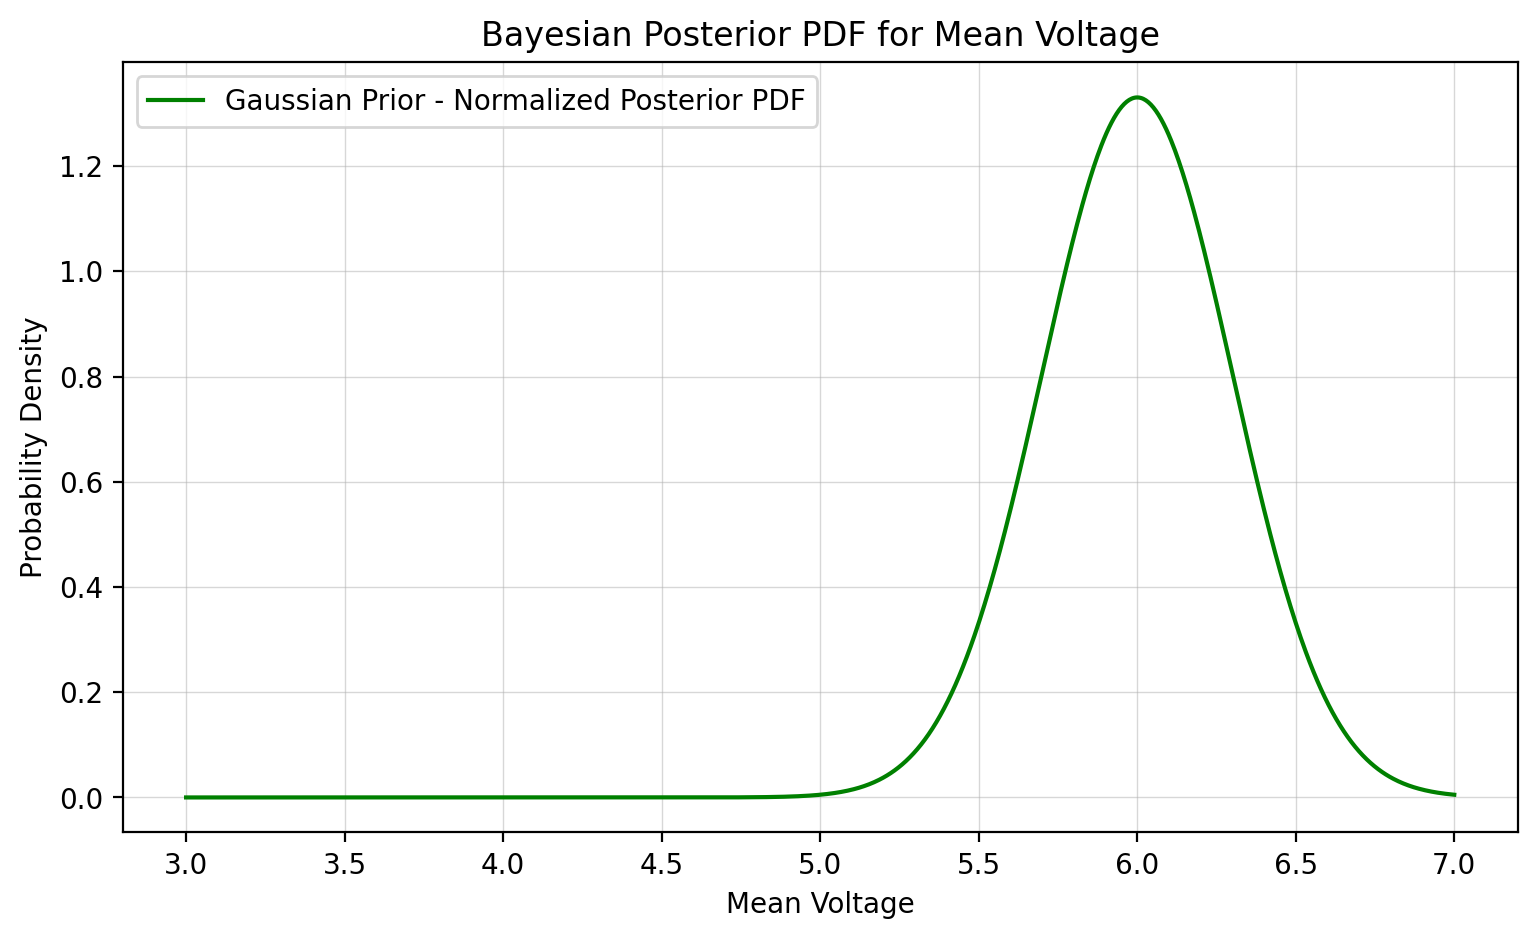

In [673]:
# create a gaussian distribution

Gmu=6
Gsigma=0.3
Gauss = scipy.stats.norm(Gmu, Gsigma)
prior3 = Gauss.pdf(mu_grid)


# Compute the likelihood for each value in the grid
# Exponentiate the Ln_Likelihood to get likelihood
likelihood3 = np.exp([-Ln_Likelihood(Gmu, x, Gsigma) for mu in mu_grid])

# Compute the posterior by multiplying the likelihood by the prior
posterior3 = likelihood3 * prior3

# Normalize the posterior (must sum to 1): dividing by the sum of all posterior values
posterior3 = posterior3 / np.sum(posterior3 * np.diff(mu_grid)[0])



# Plot the posterior
plt.figure(figsize=(9, 5))
plt.plot(mu_grid, posterior3, label='Gaussian Prior - Normalized Posterior PDF', color='g')
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior PDF for Mean Voltage')
#plt.xlim(3.0,12.0)
plt.legend()
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()


In [674]:
#By drawing samples from posterior, find the equal-tailed 68.3% credible region for the mean for Gaussian Prior

#Draw samples 
n_samples = 1000 
samples = np.random.choice(mu_grid, size=n_samples, p=posterior3/posterior3.sum()) #dividing by p.sum() needed to renormalize

# Calculate the 68.3% credible interval
lower_bound = np.percentile(samples, 15.85) #lower sections (2.14 + 13.59)
upper_bound = np.percentile(samples, 84.15) # uppder sections to 68.3 (2.14 + 13.59 + 68.3)


#Find the MAP value of the mean (For what value on x-axis does the PDF peak?)
PosteriorPeak = np.argmax(posterior3) #use argmax instead of max because np.max gives max value but argmax gives index of max value

#Find x axis value for that peak (index)
MAP = mu_grid[PosteriorPeak]


#Print everything
print("For Gaussian Prior 68.3%% credible interval: [%.4f, %.4f]" % (lower_bound, upper_bound))
print("MAP estimate of the mean voltage for Gaussian Prior: %.4f" % MAP)

For Gaussian Prior 68.3% credible interval: [5.6947, 6.2673]
MAP estimate of the mean voltage for Gaussian Prior: 5.9990


### 1.7 Plot all PDFs

<Figure size 1000x600 with 0 Axes>

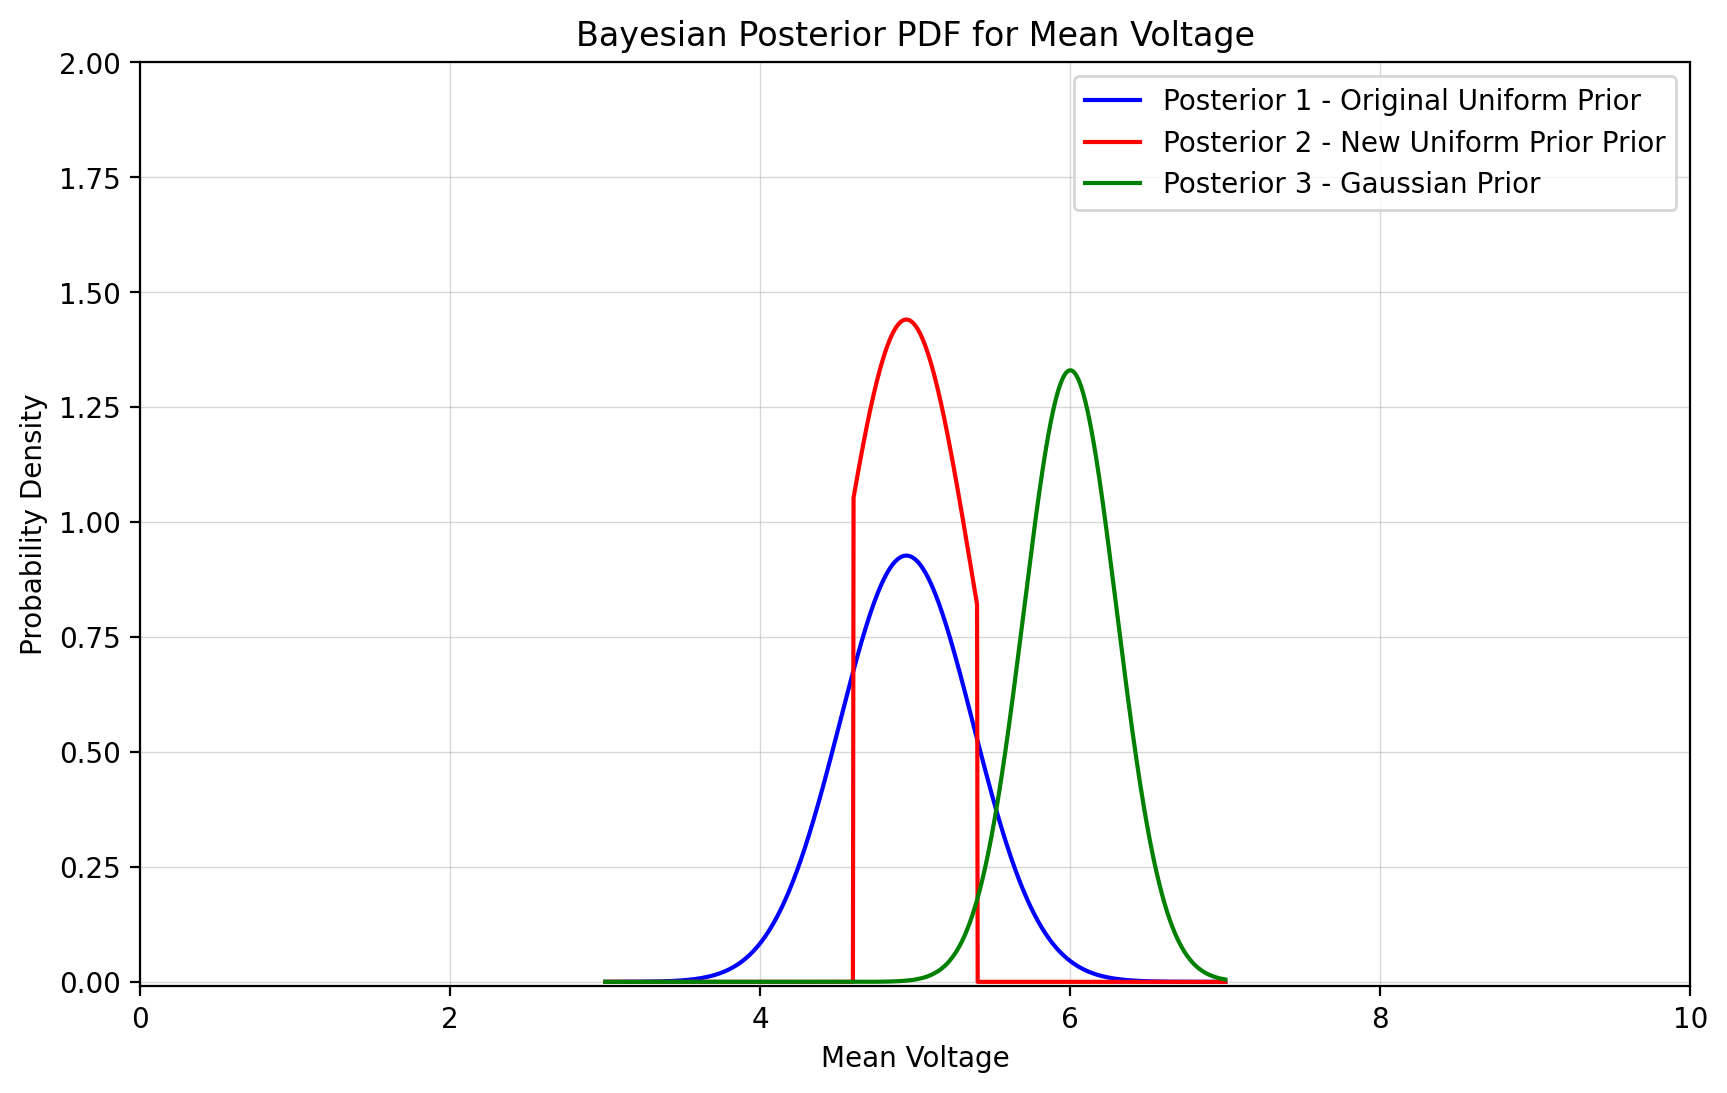

In [675]:
#Plot all of the normalized posterior pdfs for  from (3), (5), and (6) on the same plot, 
#making sure that the xlim of the plot spans 0 to 10.

# Plot the posterior
plt.figure(figsize=(10, 6))

# Plot the posterior PDFs
plt.figure(figsize=(10, 6))
plt.plot(mu_grid, posterior1, label='Posterior 1 - Original Uniform Prior', color='b')
plt.plot(mu_grid, posterior2, label='Posterior 2 - New Uniform Prior Prior', color='r')
plt.plot(mu_grid, posterior3, label='Posterior 3 - Gaussian Prior', color='g')
plt.xlim(0, 10) 
plt.ylim(-0.010,2)
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior PDF for Mean Voltage')

plt.legend()
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()


### 1.8 Bayesian Evidence

In [676]:
# Find the best-fit for Gaussian
Maximize_LnLG = optimize.minimize(Ln_Likelihood, x0=Gmu, args=(x, Gsigma))
best_fit_muG = Maximize_LnLG.x[0]


#Find Bayesian Evidence for OG model
likelihood_at_best_fit = np.exp(-Ln_Likelihood(best_fit_mu, x, sigma))
evidence = likelihood_at_best_fit

#Find Bayesian Evidence for Gaussian model
likelihood_at_best_fit3 = np.exp(-Ln_Likelihood(best_fit_muG, x, sigma))
evidence3 = likelihood_at_best_fit3

#Take ratios for Bayes factor, which model is favored? 
Ratio=evidence/evidence3

#Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly?
print("Bayesian evidence under the OG model: {:.5f}".format(evidence))
print("Bayesian evidence under the Gaussian model : {:.5f}".format(evidence3))
print("Bayesian Factor, where the Uniform Prior is the prefered model : {:.5f}".format(Ratio))


Bayesian evidence under the OG model: 0.06037
Bayesian evidence under the Gaussian model : 0.05615
Bayesian Factor, where the Uniform Prior is the prefered model : 1.07524


#### Given that one model is preferred over the other only slightly, I would say that the Occam penalty here would not apply as heavily. If we assume that the more complex model is the one using the non-uniform prior, then this model would have a higher penalty because we are more certain about the best value for that complex prior. But since they are so close, the occams penalty is not very high relative to the uniform model


## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

<span style="color:blue">


#### Problem 2 Purpose: Determine the preferred model between linear and quadratic fits by computing the Bayesian evidence. We use Bayesian evidence to asses which model best describes the data 
#####     - 1. We start with a data set
#####     - 2. We determine the unnormalized posterior 
#####     - 3. We find the Bayesian Evidence in 1D 
#####     - 4. We calculate the joint 2D posterior 
#####     - 5. We find the Bayesian Evidence in 2D 
#####     - 6. We determine Bayes factor for linear vs quadratic model


<span/>

### Solution 2

### 2.1 Read in Data

In [677]:
# Load the dataset 
data = np.load('/Users/jarretsm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw4_data_2.npy') 

# Extract data
x = data[0, :] #first column is measurements
y = data[1, :] #first column is measurements
sigma_y = data[2, :] #Second column is uncertainties

print, min(x), max(x), min(y), max(y)

(<function print>, 0.0, 0.88, -0.25, 0.58)

### 2.2 Compute and plot the Bayesian posterior probability density

In [678]:
#Find the posterior 

# Write the log likelihood function 
#A polynomial fit will determine what slope best fits my linear data
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # Theta is slope
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood based on the linear polynomial fits
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# Grid of all possible linear slopes
theta_grid = np.linspace(-10, 10, 100)  # For example, 100 slopes between 0.5 and 1.5


# Compute the likelihood for each theta (slope) in the grid with a fixed y-intercept
Fixed_y_Intercept= -0.23
likelihoods = np.exp([-logL([Fixed_y_Intercept, slope], data) for slope in theta_grid])


/var/folders/5c/kkcpl36x6c78d36n8pktxwjm0000gr/T/ipykernel_60599/1787179697.py:23: RuntimeWarning: overflow encountered in exp
  likelihoods = np.exp([-logL([Fixed_y_Intercept, slope], data) for slope in theta_grid])


/var/folders/5c/kkcpl36x6c78d36n8pktxwjm0000gr/T/ipykernel_60599/1431478695.py:10: RuntimeWarning: overflow encountered in exp
  likelihoods = np.exp([-logL([Fixed_y_Intercept, slope], data) for slope in theta_grid])
/var/folders/5c/kkcpl36x6c78d36n8pktxwjm0000gr/T/ipykernel_60599/1431478695.py:13: RuntimeWarning: invalid value encountered in multiply
  posterior = likelihoods * prior


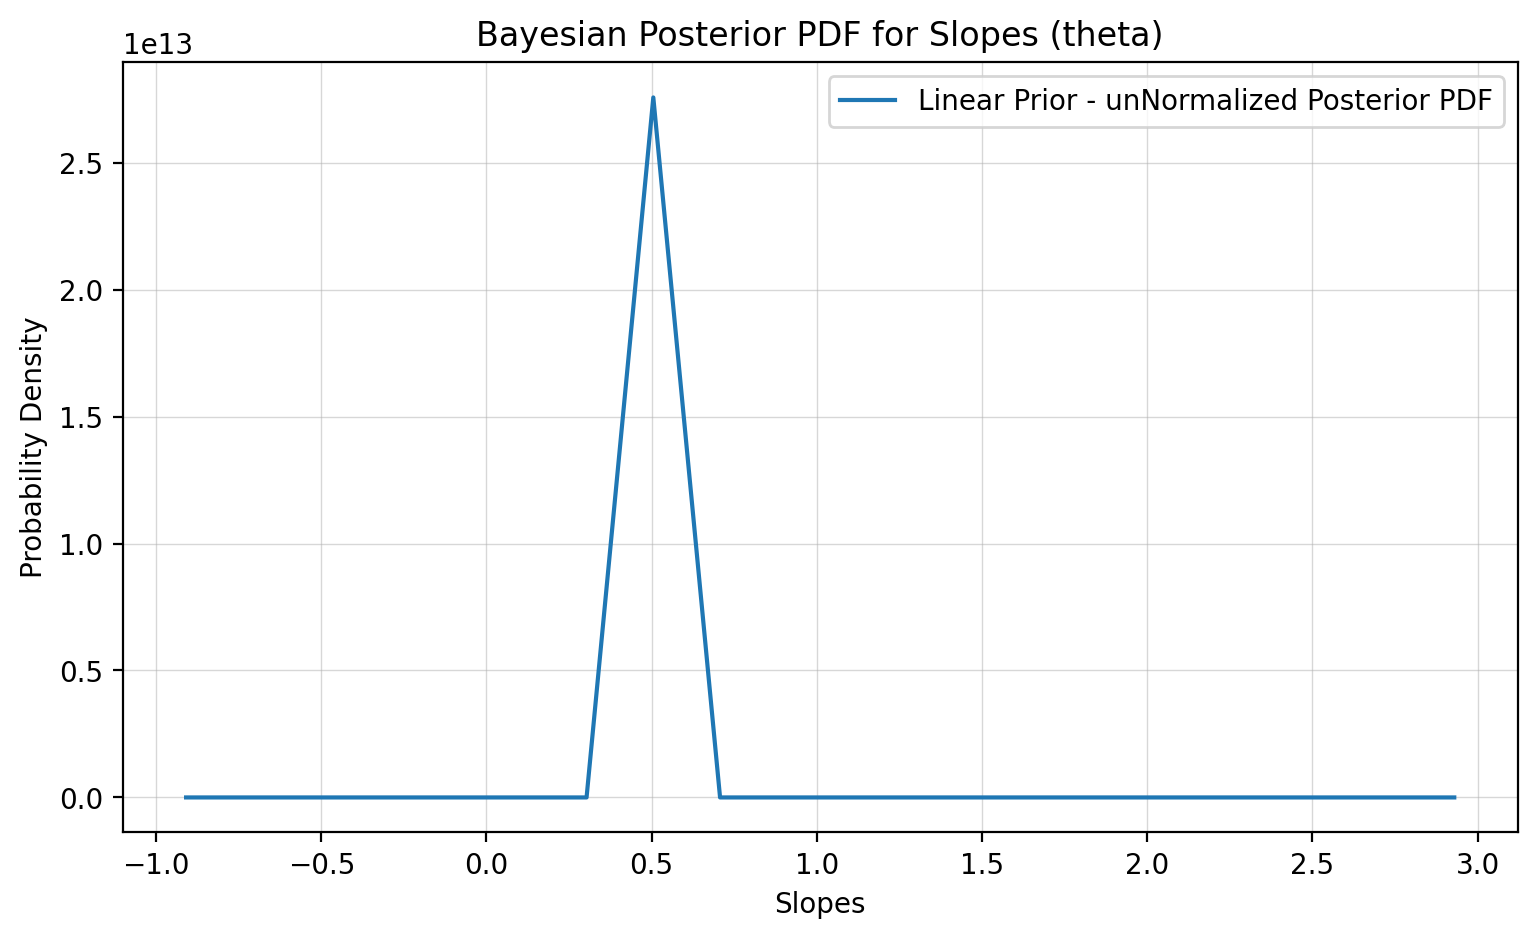

In [679]:
# Calculate the uniform prior

#Select min and max values of the voltage data (about 3 and 7)
X_Min=0.5
X_Max=1.5

# Define the uniform prior
prior = uniform.pdf(theta_grid, loc=X_Min, scale= X_Max-X_Min) 

likelihoods = np.exp([-logL([Fixed_y_Intercept, slope], data) for slope in theta_grid])

# Compute the posterior by multiplying the likelihood by the prior
posterior = likelihoods * prior

# Plot the posterior
plt.figure(figsize=(9, 5))
plt.plot(theta_grid, posterior, label='Linear Prior - unNormalized Posterior PDF')
plt.xlabel('Slopes')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior PDF for Slopes (theta)')
#plt.xlim(0,0.6)
plt.legend()
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()


### 2.3 Calculate the Bayesian Evidence for 1D

In [680]:
# Minimize the negative log-likelihood using a lambda function
result = optimize.minimize(lambda theta: -logL(theta, data, polynomial_fit), 0.5)

# Best-fit parameters
best_fit_theta = result.x

# Compute the likelihood at the best-fit parameters
likelihood_at_best_fit = (np.exp(logL(best_fit_theta, data, polynomial_fit)))**-1

# The likelihood itself is considered as the evidence in this context
evidence = likelihood_at_best_fit
print("Bayesian evidence under the 1D linear model: {:.2e}".format(evidence))

Bayesian evidence under the 1D linear model: 1.69e+15


### 2.4 Plot 2d Posterior

In [681]:

# Assuming the data is already loaded
# x, y, sigma_y = data
data = np.array([x, y, sigma_y])

# Define the quadratic polynomial fit function
def polynomial_fit(theta, x):
    """Quadratic model considering linear and quadratic coefficients with fixed intercept."""
    intercept, linear, quadratic = theta
    return intercept + linear * x + quadratic * x**2

# Define the log likelihood function using your definition
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return np.sum(scipy.stats.norm.pdf(y, loc=y_fit, scale=sigma_y))


In [682]:
# Fixed intercept
fixed_intercept = -0.23

# Define the grids for linear and quadratic coefficients
linear_coeff_grid = np.linspace(0, 1.5, 50)
quadratic_coeff_grid = np.linspace(-1, 0.25, 50)

# Create a 2D grid of coefficients
linear_grid, quadratic_grid = np.meshgrid(linear_coeff_grid, quadratic_coeff_grid)

# Initialize the grid for log likelihood values
log_likelihood_grid = np.zeros_like(linear_grid)

# Compute the log likelihood for each combination of coefficients
for i in range(linear_grid.shape[0]):
    for j in range(linear_grid.shape[1]):
        theta = [fixed_intercept, linear_grid[i, j], quadratic_grid[i, j]]
        log_likelihood_grid[i, j] = logL(theta, data)

# Convert log likelihood to likelihood
likelihood_grid = np.exp(log_likelihood_grid)


In [683]:

# Define uniform priors for the coefficients
#prior_linear = uniform.pdf(linear_coeff_grid, loc=0.5, scale=1.0 - 0.5)
prior_linear = uniform.pdf(linear_coeff_grid, loc=0.5, scale=0.5)
prior_quadratic = uniform.pdf(quadratic_coeff_grid, loc=-1.0, scale=0.25 - (-1))

# Compute the 2D prior grid by taking the outer product of the individual priors
prior_grid = np.outer(prior_quadratic, prior_linear)

# Compute the unnormalized posterior by multiplying the likelihood and prior grids
posterior_grid = likelihood_grid * prior_grid 


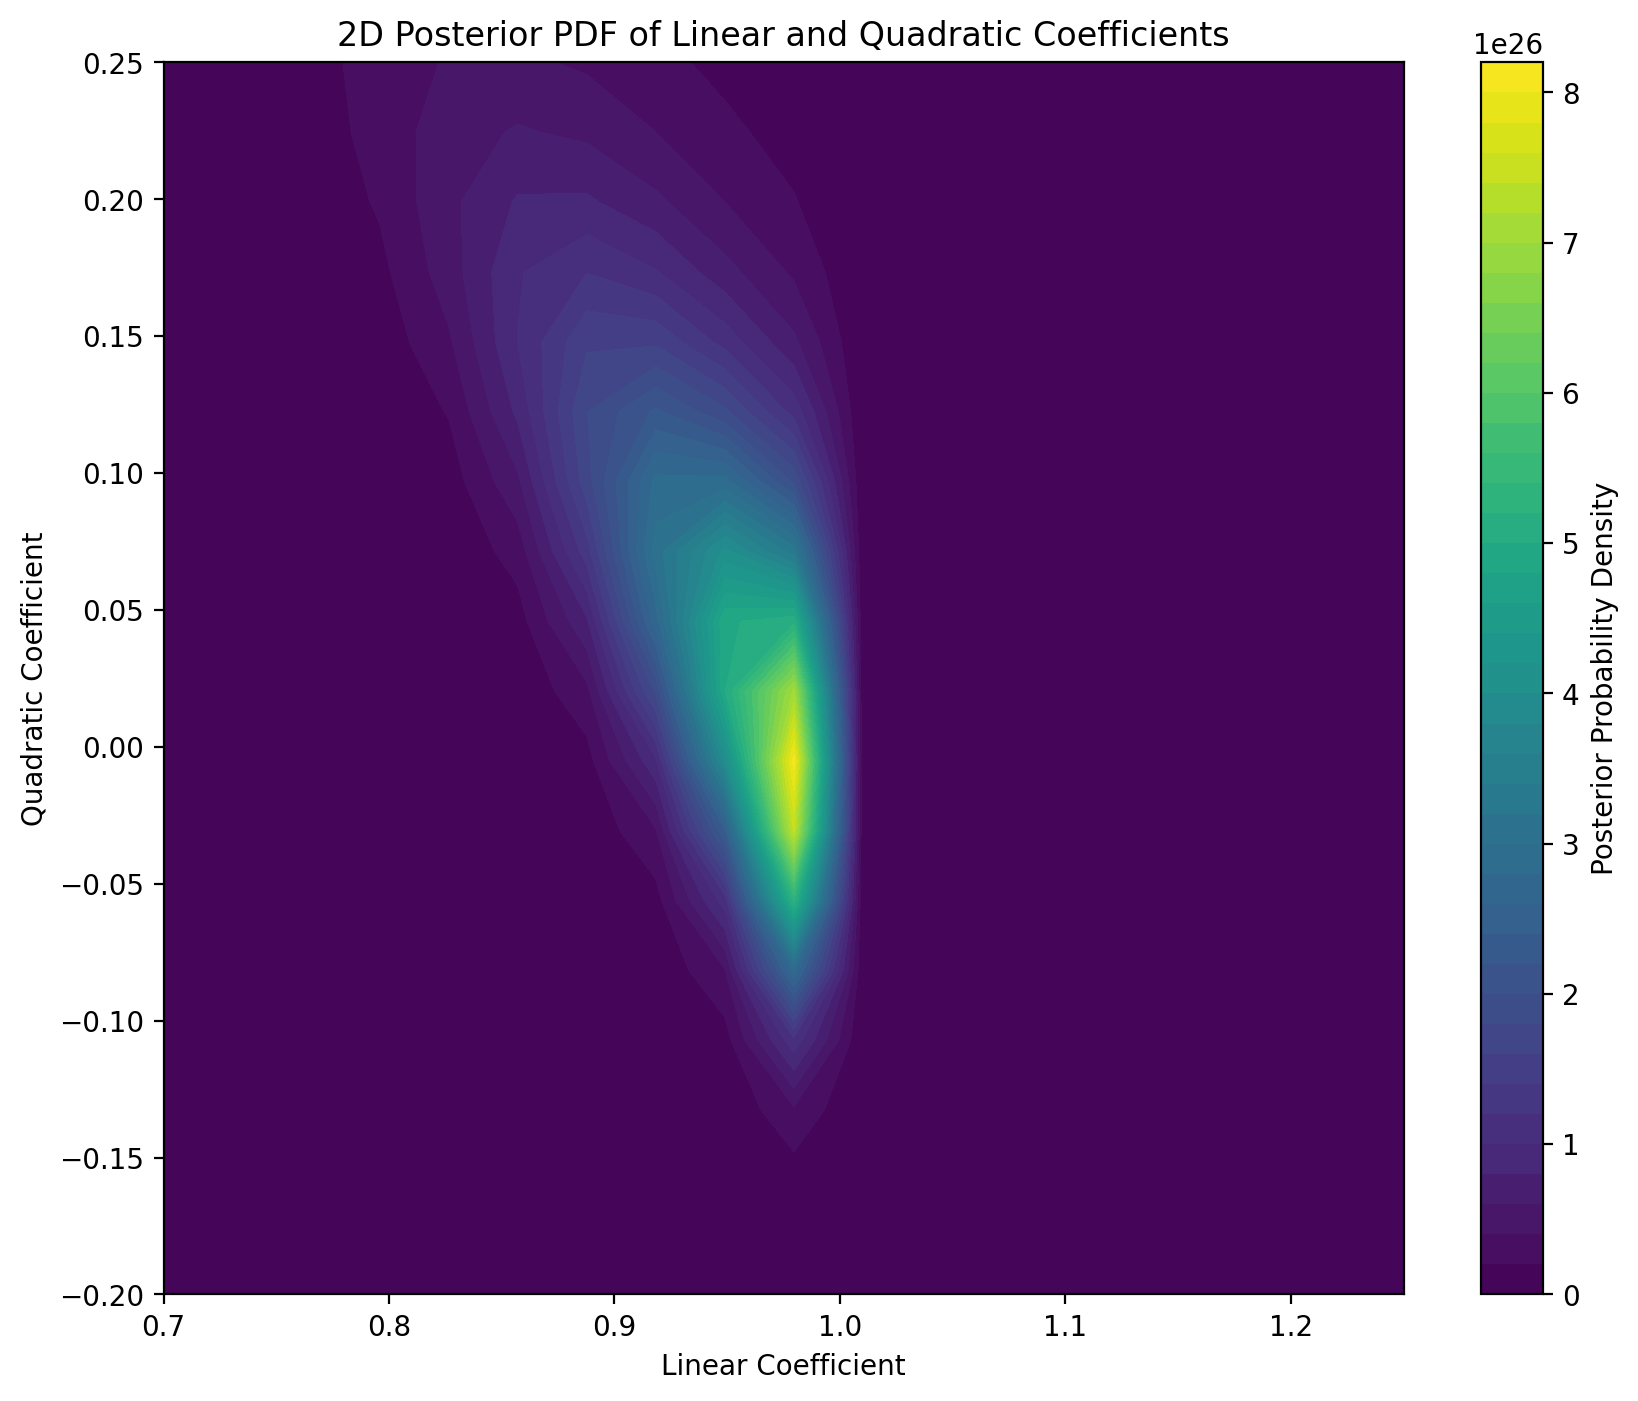

In [684]:
# #Plot the 2D posterior distribution
plt.figure(figsize=(10, 8))
plt.contourf(linear_grid, quadratic_grid, posterior_grid, levels=50, cmap='viridis')
plt.xlabel('Linear Coefficient')
plt.ylabel('Quadratic Coefficient')
plt.ylim(-0.2,.25)
plt.xlim(0.7,1.25)
plt.title('2D Posterior PDF of Linear and Quadratic Coefficients')
plt.colorbar(label='Posterior Probability Density')
plt.show()



### 2.5 Calculate the Bayesian Evidence for 2D

In [685]:
# Minimize the negative log-likelihood using a lambda function
result = optimize.minimize(lambda theta: -logL(theta, data, polynomial_fit), [0.5, 1.0, 1.5])

# Best-fit parameters
best_fit_theta = result.x

# Compute the likelihood at the best-fit parameters
likelihood_at_best_fit = (np.exp(logL(best_fit_theta, data, polynomial_fit)))

# The likelihood itself is considered as the evidence in this context
evidence3 = likelihood_at_best_fit
print("Bayesian evidence under the 2D quadratic model: {:.2e}".format(evidence3))

Bayesian evidence under the 2D quadratic model: 1.00e+00


### 1.6) Calculate the Bayes factor

In [687]:
#Calculate the Bayes factor for a linear versus quadratic model. 

#Take ratios for Bayes factor, which model is favored? 
Ratio=evidence/evidence3

print("Bayesian Factor, where the Linear Model is the prefered model (this seems weirdly high) : {:.2e}".format(Ratio))

Bayesian Factor, where the Linear Model is the prefered model (this seems weirdly high) : 1.69e+15


#### If I obtained a reasonable number, this compares with the BIC model from lecture because BIC uses the maximum value of the liklihood instead of integrating, and the model that has the lowest value is the best model. With Bayes factor ratios, if the ratio is larger the model in the numerator is the winning model. BIC also penalizes more complex models.  
 
